### どこで誤差が生じているかEDAをして確認する

In [87]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib
font = {'family': 'Yu Mincho'}
matplotlib.rc('font', **font)

pd.set_option('max_columns',1000)
pd.set_option('max_rows',1000)

import warnings
warnings.filterwarnings('ignore')

import re
import geocoder
from geopy.distance import great_circle, vincenty
from tqdm import tqdm
from sklearn.metrics import mean_squared_error


import os
import gc
# print(os.listdir("././input"))
# print(os.listdir("././submit"))

SEED=1234
n_splits=10

### check_LeaderBoard

In [6]:
df=pd.read_table('./input/leaderboard.txt',header=None)
df[1]=range(1,59)

[]

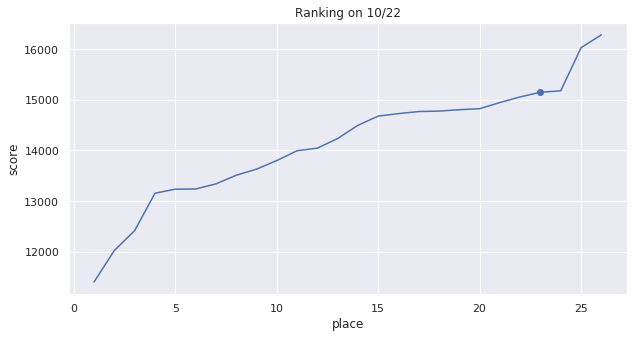

In [62]:
plt.figure(figsize=(10,5))
palette = sns.color_palette("mako_r", 1)
sns.lineplot(x=1,y=0,markers=True,palette=palette, dashes=True,data=df.loc[:25,:])
plt.scatter(23,15148)
plt.title('Ranking on 10/22')
plt.ylabel('score')
plt.xlabel('place')
plt.savefig('./input/now_place.png')
plt.plot()

In [63]:
train=pd.read_csv('./input/pred_train.csv')
test=pd.read_csv('./input/pred_test.csv')

### Location

In [65]:
test.head(1)

,Unnamed: 0,id,契約期間,建物構造,所在階,方角,築年数,賃料,間取り,面積,駐車場,-,専用トイレ,洗面台独立,追焚機能,専用バス,バス・トイレ別,温水洗浄便座,脱衣所,バスなし,共同バス,トイレなし,浴室乾燥機,共同トイレ,シャワー,駅名,新築,畳,光ファイバー,インターネット使用料無料,有線放送,BSアンテナ,インターネット対応,CSアンテナ,高速インターネット,CATV,loc_lat,loc_lon,center_dis,city,city2,借家,契約期間(まで),【郵便局】_dis,【郵便局】_num,【小学校】_dis,【小学校】_num,【飲食店】_dis,【飲食店】_num,【コンビニ】_dis,【コンビニ】_num,【幼稚園・保育園】_dis,【幼稚園・保育園】_num,【図書館】_dis,【図書館】_num,【総合病院】_dis,【総合病院】_num,【学校】_dis,【学校】_num,【レンタルビデオ】_dis,【レンタルビデオ】_num,【銀行】_dis,【銀行】_num,【クリーニング】_dis,【クリーニング】_num,【デパート】_dis,【デパート】_num,【コインパーキング】_dis,【コインパーキング】_num,【月極駐車場】_dis,【月極駐車場】_num,【病院】_dis,【病院】_num,【公園】_dis,【公園】_num,【ドラッグストア】_dis,【ドラッグストア】_num,【スーパー】_dis,【スーパー】_num,【大学】_dis,【大学】_num,石油暖房,浄化槽,フローリング,床暖房,ウォークインクローゼット,トランクルーム,プロパンガス,バリアフリー,ガス暖房,冷房,都市ガス,ルーフバルコニー,防音室,室外洗濯機置場,オール電化,シューズボックス,下水,出窓,ペアガラス,二重サッシ,洗濯機置場なし,地下室,3面採光,敷地内ごみ置き場,汲み取り,ガスその他,公営水道,水道その他,クッションフロア,2面採光,エアコン付,床下収納,エレベーター,タイル張り,専用庭,ロフト付き,井戸,二世帯住宅,24時間換気システム,排水その他,バルコニー,室内洗濯機置場,戸建て,総階数,地下階数,納戸,部屋数,L,D,K,LDK,DK,コンロ2口,コンロ3口,コンロ1口,カウンターキッチン,コンロ4口以上,コンロ設置可（コンロ4口以上）,IHコンロ,電気コンロ,給湯,冷蔵庫あり,コンロ設置可（コンロ3口）,コンロ設置可（コンロ1口）,独立キッチン,ガスコンロ,コンロ設置可（コンロ2口）,システムキッチン,コンロ設置可（口数不明）,L字キッチン,駐輪場,バイク置き場,sta_lat,sta_lon,station_dis,station_dis_min,station_num,nearest_station,2012年平均単価,2017年平均単価,上昇率,2012平均単価_mean,2012平均単価_max,2012平均単価_min,2017平均単価_mean,2017平均単価_max,2017平均単価_min,上昇率_mean,上昇率_max,上昇率_min,target
0,0,31471,0,鉄骨造,8.0,南,588,NaN,2LDK,50.0,無,0,1,1,1,1,1,1,1,0,0,0,0,0,1,等々力駅,0,34,0,0,0,0,1,0,0,0,35.61772,139.652763,10561.359582,世田谷区,深沢,0,0,0,0,219,1,0,0,74,1,0,0,0,0,0,0,252,1,0,0,0,0,0,0,0,0,0,0,0,0,313,1,0,0,0,0,215,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,8.0,0,0,2,1,1,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,空有,-,35.608349,139.648072,1123.253453,1123.253453,3,1,604940.0,649639.0,7.4,615371.0,631013.0,604940.0,698755.333333,749667.0,649639.0,13.466667,18.8,7.4,109723.682454


In [144]:
loc_tr=train[['id','y_train','oof','loc_lat','loc_lon']]
loc_te=test[['target','loc_lat','loc_lon']]
loc_tr['diff']=loc_tr['oof']-loc_tr['y_train']

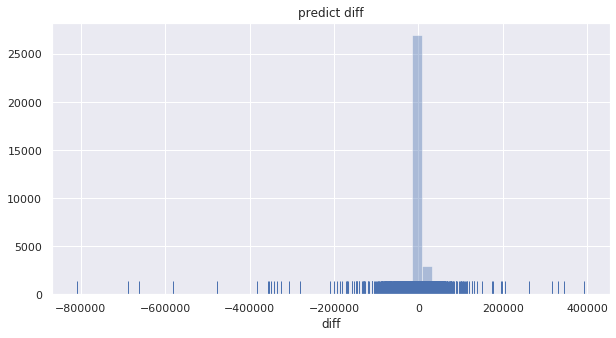

In [145]:
#低く見積もれがち
plt.figure(figsize=(10,5))
plt.title('predict diff')
sns.distplot(loc_tr['diff'],rug=True, norm_hist=False,kde=False)
plt.show()

In [146]:
loc_tr2=loc_tr.copy()
loc_tr2.loc[loc_tr2['diff']>200000,'oof']=loc_tr2['y_train']
print('20万以上高く見積もられている建物の数:',len(loc_tr2.loc[loc_tr2['diff']>200000,'oof']))
print('これらを正しく予測できたときのRMSE:',np.sqrt(mean_squared_error(loc_tr2['oof'], loc_tr2['y_train'])))

loc_tr2=loc_tr.copy()
print('20万以上安く見積もられている建物の数:',len(loc_tr2.loc[loc_tr2['diff']<-200000,'oof']))
loc_tr2.loc[loc_tr2['diff']<-200000,'oof']=loc_tr2['y_train']
print('これらを正しく予測できたときのRMSE:',np.sqrt(mean_squared_error(loc_tr2['oof'], loc_tr2['y_train'])))
print()
loc_tr2=loc_tr.copy()
loc_tr2.loc[loc_tr2['diff']>100000,'oof']=loc_tr2['y_train']
print('10万以上高く見積もられている建物の数:',len(loc_tr2.loc[loc_tr2['diff']>100000,'oof']))
print('これらを正しく予測できたときのRMSE:',np.sqrt(mean_squared_error(loc_tr2['oof'], loc_tr2['y_train'])))

loc_tr2=loc_tr.copy()
print('10万以上安く見積もられている建物の数:',len(loc_tr2.loc[loc_tr2['diff']<-100000,'oof']))
loc_tr2.loc[loc_tr2['diff']<-100000,'oof']=loc_tr2['y_train']
print('これらを正しく予測できたときのRMSE:',np.sqrt(mean_squared_error(loc_tr2['oof'], loc_tr2['y_train'])))

20万以上高く見積もられている建物の数: 6
これらを正しく予測できたときのRMSE: 15436.166208354653
20万以上安く見積もられている建物の数: 16
これらを正しく予測できたときのRMSE: 12409.546144002277

10万以上高く見積もられている建物の数: 28
これらを正しく予測できたときのRMSE: 15031.464823890046
10万以上安く見積もられている建物の数: 48
これらを正しく予測できたときのRMSE: 11549.387494781471


In [147]:
loc_tr['abs']=np.abs(loc_tr['diff'])

In [148]:
loc_tr2=loc_tr.sort_values('abs',ascending=False)[:300]

In [150]:
import chart_studio
chart_studio.tools.set_credentials_file(username='zerebom', api_key='pk.eyJ1IjoiemVyZWJvbSIsImEiOiJjanpjY2JkZWUwMHMwM2RwNmQyanM2cHg4In0.VvajXw6UybbJhgp_-fHeY')
chart_studio.tools.set_config_file(world_readable=False,
                             sharing='private')

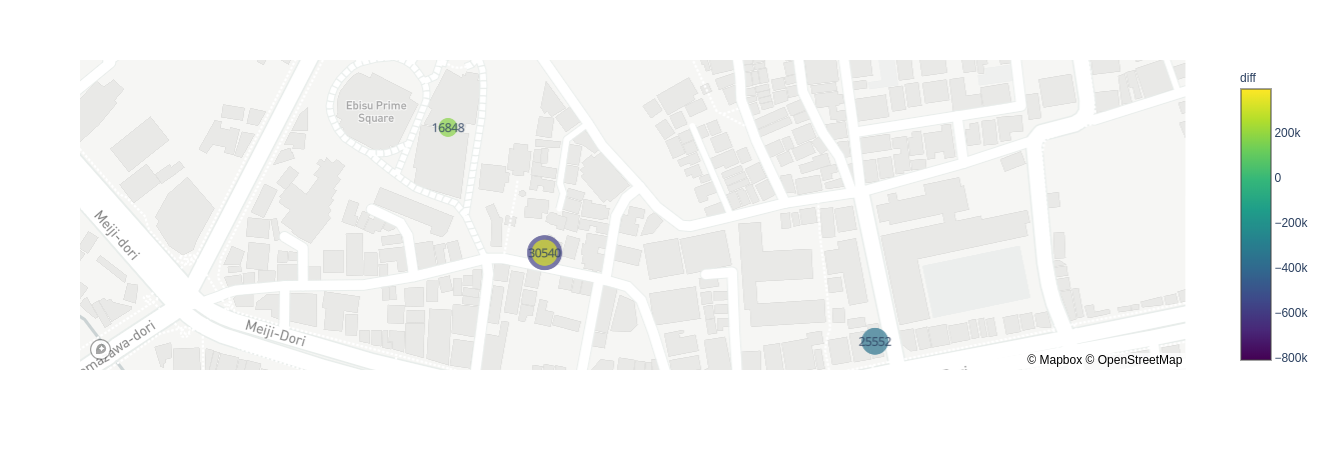

In [152]:
import plotly.express as px
px.set_mapbox_access_token('pk.eyJ1IjoiemVyZWJvbSIsImEiOiJjanpjY2JkZWUwMHMwM2RwNmQyanM2cHg4In0.VvajXw6UybbJhgp_-fHeYw')
fig = px.scatter_mapbox(loc_tr2, lat="loc_lat", lon="loc_lon",  color="diff", size="abs",text='id',
                  color_continuous_scale=px.colors.sequential.Viridis, size_max=30, zoom=10)
fig.show()


誤差が大きい300個を確認  
何箇所か同じ場所で誤差が大きい場所がある

外れ値のマンションを実際に確認。 
麻布十番のマンション
築年数が20年目なので低めに出てしまうのかも。  
testにも同じ物件が一つ存在する。面積と階数が同じことからおそらく180万円（予測は160万と出てしまっている)  
一つの建物で家賃の分散が大きいもののTEは平均×分散などでスケールを調整したほうがいいかも 
https://mansion-market.com/mansions/detail/13374#market

In [170]:
display(train.loc[train['loc_lat']==35.6518157])
display(test.loc[test['loc_lat']==35.6518157])

,id,契約期間,建物構造,所在階,方角,築年数,賃料,間取り,面積,駐車場,-,専用トイレ,洗面台独立,追焚機能,専用バス,バス・トイレ別,温水洗浄便座,脱衣所,バスなし,共同バス,トイレなし,浴室乾燥機,共同トイレ,シャワー,駅名,新築,畳,光ファイバー,インターネット使用料無料,有線放送,BSアンテナ,インターネット対応,CSアンテナ,高速インターネット,CATV,loc_lat,loc_lon,center_dis,city,city2,借家,契約期間(まで),【郵便局】_dis,【郵便局】_num,【小学校】_dis,【小学校】_num,【飲食店】_dis,【飲食店】_num,【コンビニ】_dis,【コンビニ】_num,【幼稚園・保育園】_dis,【幼稚園・保育園】_num,【図書館】_dis,【図書館】_num,【総合病院】_dis,【総合病院】_num,【学校】_dis,【学校】_num,【レンタルビデオ】_dis,【レンタルビデオ】_num,【銀行】_dis,【銀行】_num,【クリーニング】_dis,【クリーニング】_num,【デパート】_dis,【デパート】_num,【コインパーキング】_dis,【コインパーキング】_num,【月極駐車場】_dis,【月極駐車場】_num,【病院】_dis,【病院】_num,【公園】_dis,【公園】_num,【ドラッグストア】_dis,【ドラッグストア】_num,【スーパー】_dis,【スーパー】_num,【大学】_dis,【大学】_num,石油暖房,浄化槽,フローリング,床暖房,ウォークインクローゼット,トランクルーム,プロパンガス,バリアフリー,ガス暖房,冷房,都市ガス,ルーフバルコニー,防音室,室外洗濯機置場,オール電化,シューズボックス,下水,出窓,ペアガラス,二重サッシ,洗濯機置場なし,地下室,3面採光,敷地内ごみ置き場,汲み取り,ガスその他,公営水道,水道その他,クッションフロア,2面採光,エアコン付,床下収納,エレベーター,タイル張り,専用庭,ロフト付き,井戸,二世帯住宅,24時間換気システム,排水その他,バルコニー,室内洗濯機置場,戸建て,総階数,地下階数,納戸,部屋数,L,D,K,LDK,DK,コンロ2口,コンロ3口,コンロ1口,カウンターキッチン,コンロ4口以上,コンロ設置可（コンロ4口以上）,IHコンロ,電気コンロ,給湯,冷蔵庫あり,コンロ設置可（コンロ3口）,コンロ設置可（コンロ1口）,独立キッチン,ガスコンロ,コンロ設置可（コンロ2口）,システムキッチン,コンロ設置可（口数不明）,L字キッチン,駐輪場,バイク置き場,sta_lat,sta_lon,station_dis,station_dis_min,station_num,nearest_station,2012年平均単価,2017年平均単価,上昇率,2012平均単価_mean,2012平均単価_max,2012平均単価_min,2017平均単価_mean,2017平均単価_max,2017平均単価_min,上昇率_mean,上昇率_max,上昇率_min,y_train,oof
2908,2910,36,RC（鉄筋コンクリート）,3.0,南,20,700000.0,2LDK,103.04,空有,0,1,1,1,1,0,1,1,0,0,0,1,0,1,麻布十番駅,0,71,1,0,0,1,1,1,0,0,35.651816,139.741531,2694.513318,港区,三田,1,0,0,0,0,0,0,0,595,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,627,3,0,0,0,0,1,1,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,1,0,9.0,0,0,2,1,1,1,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,空有,-,35.656134,139.736881,637.804238,416.796804,3,0,769366.0,998185.0,29.7,661848.333333,769366.0,564371.0,868956.0,998185.0,755032.0,31.5,33.8,29.7,700000.0,8.154714e+05
5092,5094,36,RC（鉄筋コンクリート）,9.0,西,20,2500000.0,2LDK,217.29,空有,0,1,1,1,1,1,1,1,0,0,0,1,0,1,麻布十番駅,0,149,0,0,0,0,1,0,0,0,35.651816,139.741531,2694.513318,港区,三田,1,0,0,0,0,0,959,2,505,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,417,2,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,1,0,9.0,2,1,2,1,1,1,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,-,-,35.656134,139.736881,637.804238,416.796804,3,0,769366.0,998185.0,29.7,661848.333333,769366.0,564371.0,868956.0,998185.0,755032.0,31.5,33.8,29.7,2500000.0,1.691126e+06
20638,20644,36,RC（鉄筋コンクリート）,5.0,南,20,1800000.0,2LDK,151.81,空有,0,1,1,1,1,1,1,1,0,0,0,1,0,1,麻布十番駅,0,104,0,0,0,0,1,0,0,0,35.651816,139.741531,2694.513318,港区,三田,1,0,0,0,0,0,959,2,505,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,417,2,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,1,0,9.0,2,1,2,1,1,1,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,-,-,35.656134,139.736881,637.804238,416.796804,3,0,769366.0,998185.0,29.7,661848.333333,769366.0,564371.0,868956.0,998185.0,755032.0,31.5,33.8,29.7,1800000.0,1.446173e+06


,Unnamed: 0,id,契約期間,建物構造,所在階,方角,築年数,賃料,間取り,面積,駐車場,-,専用トイレ,洗面台独立,追焚機能,専用バス,バス・トイレ別,温水洗浄便座,脱衣所,バスなし,共同バス,トイレなし,浴室乾燥機,共同トイレ,シャワー,駅名,新築,畳,光ファイバー,インターネット使用料無料,有線放送,BSアンテナ,インターネット対応,CSアンテナ,高速インターネット,CATV,loc_lat,loc_lon,center_dis,city,city2,借家,契約期間(まで),【郵便局】_dis,【郵便局】_num,【小学校】_dis,【小学校】_num,【飲食店】_dis,【飲食店】_num,【コンビニ】_dis,【コンビニ】_num,【幼稚園・保育園】_dis,【幼稚園・保育園】_num,【図書館】_dis,【図書館】_num,【総合病院】_dis,【総合病院】_num,【学校】_dis,【学校】_num,【レンタルビデオ】_dis,【レンタルビデオ】_num,【銀行】_dis,【銀行】_num,【クリーニング】_dis,【クリーニング】_num,【デパート】_dis,【デパート】_num,【コインパーキング】_dis,【コインパーキング】_num,【月極駐車場】_dis,【月極駐車場】_num,【病院】_dis,【病院】_num,【公園】_dis,【公園】_num,【ドラッグストア】_dis,【ドラッグストア】_num,【スーパー】_dis,【スーパー】_num,【大学】_dis,【大学】_num,石油暖房,浄化槽,フローリング,床暖房,ウォークインクローゼット,トランクルーム,プロパンガス,バリアフリー,ガス暖房,冷房,都市ガス,ルーフバルコニー,防音室,室外洗濯機置場,オール電化,シューズボックス,下水,出窓,ペアガラス,二重サッシ,洗濯機置場なし,地下室,3面採光,敷地内ごみ置き場,汲み取り,ガスその他,公営水道,水道その他,クッションフロア,2面採光,エアコン付,床下収納,エレベーター,タイル張り,専用庭,ロフト付き,井戸,二世帯住宅,24時間換気システム,排水その他,バルコニー,室内洗濯機置場,戸建て,総階数,地下階数,納戸,部屋数,L,D,K,LDK,DK,コンロ2口,コンロ3口,コンロ1口,カウンターキッチン,コンロ4口以上,コンロ設置可（コンロ4口以上）,IHコンロ,電気コンロ,給湯,冷蔵庫あり,コンロ設置可（コンロ3口）,コンロ設置可（コンロ1口）,独立キッチン,ガスコンロ,コンロ設置可（コンロ2口）,システムキッチン,コンロ設置可（口数不明）,L字キッチン,駐輪場,バイク置き場,sta_lat,sta_lon,station_dis,station_dis_min,station_num,nearest_station,2012年平均単価,2017年平均単価,上昇率,2012平均単価_mean,2012平均単価_max,2012平均単価_min,2017平均単価_mean,2017平均単価_max,2017平均単価_min,上昇率_mean,上昇率_max,上昇率_min,target
2823,2823,34294,36,RC（鉄筋コンクリート）,5.0,南,20,NaN,2LDK,151.81,空有,0,1,1,1,1,0,1,1,0,0,0,1,0,1,麻布十番駅,0,104,1,0,0,1,1,1,0,0,35.651816,139.741531,2694.513318,港区,三田,1,0,0,0,0,0,0,0,595,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,627,3,0,0,0,0,1,1,1,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,1,0,9.0,0,0,2,1,1,1,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,空有,-,35.656134,139.736881,637.804238,416.796804,3,0,769366.0,998185.0,29.7,661848.333333,769366.0,564371.0,868956.0,998185.0,755032.0,31.5,33.8,29.7,1.637651e+06


広尾のマンション。  　
かなりの物件数あり、階層により全然値段が違う

In [181]:
display(train.loc[(train['loc_lon']==139.7137957)&(train['loc_lat']==35.6492266)])

,id,契約期間,建物構造,所在階,方角,築年数,賃料,間取り,面積,駐車場,-,専用トイレ,洗面台独立,追焚機能,専用バス,バス・トイレ別,温水洗浄便座,脱衣所,バスなし,共同バス,トイレなし,浴室乾燥機,共同トイレ,シャワー,駅名,新築,畳,光ファイバー,インターネット使用料無料,有線放送,BSアンテナ,インターネット対応,CSアンテナ,高速インターネット,CATV,loc_lat,loc_lon,center_dis,city,city2,借家,契約期間(まで),【郵便局】_dis,【郵便局】_num,【小学校】_dis,【小学校】_num,【飲食店】_dis,【飲食店】_num,【コンビニ】_dis,【コンビニ】_num,【幼稚園・保育園】_dis,【幼稚園・保育園】_num,【図書館】_dis,【図書館】_num,【総合病院】_dis,【総合病院】_num,【学校】_dis,【学校】_num,【レンタルビデオ】_dis,【レンタルビデオ】_num,【銀行】_dis,【銀行】_num,【クリーニング】_dis,【クリーニング】_num,【デパート】_dis,【デパート】_num,【コインパーキング】_dis,【コインパーキング】_num,【月極駐車場】_dis,【月極駐車場】_num,【病院】_dis,【病院】_num,【公園】_dis,【公園】_num,【ドラッグストア】_dis,【ドラッグストア】_num,【スーパー】_dis,【スーパー】_num,【大学】_dis,【大学】_num,石油暖房,浄化槽,フローリング,床暖房,ウォークインクローゼット,トランクルーム,プロパンガス,バリアフリー,ガス暖房,冷房,都市ガス,ルーフバルコニー,防音室,室外洗濯機置場,オール電化,シューズボックス,下水,出窓,ペアガラス,二重サッシ,洗濯機置場なし,地下室,3面採光,敷地内ごみ置き場,汲み取り,ガスその他,公営水道,水道その他,クッションフロア,2面採光,エアコン付,床下収納,エレベーター,タイル張り,専用庭,ロフト付き,井戸,二世帯住宅,24時間換気システム,排水その他,バルコニー,室内洗濯機置場,戸建て,総階数,地下階数,納戸,部屋数,L,D,K,LDK,DK,コンロ2口,コンロ3口,コンロ1口,カウンターキッチン,コンロ4口以上,コンロ設置可（コンロ4口以上）,IHコンロ,電気コンロ,給湯,冷蔵庫あり,コンロ設置可（コンロ3口）,コンロ設置可（コンロ1口）,独立キッチン,ガスコンロ,コンロ設置可（コンロ2口）,システムキッチン,コンロ設置可（口数不明）,L字キッチン,駐輪場,バイク置き場,sta_lat,sta_lon,station_dis,station_dis_min,station_num,nearest_station,2012年平均単価,2017年平均単価,上昇率,2012平均単価_mean,2012平均単価_max,2012平均単価_min,2017平均単価_mean,2017平均単価_max,2017平均単価_min,上昇率_mean,上昇率_max,上昇率_min,y_train,oof
84,85,24,RC（鉄筋コンクリート）,4.0,北東,140,163000.0,1R,29.51,空有,0,1,0,0,1,1,0,0,0,0,0,1,0,1,恵比寿駅,0,20,0,0,0,0,1,0,0,0,35.649227,139.713796,4096.221,渋谷区,広尾,0,0,0,0,0,0,0,0,84,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,908,2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,1,0,8.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,無,-,35.646714,139.710078,437.148808,437.148808,3,1,767187.0,959620.0,25.0,779609.666667,798061.0,767187.0,985376.0,1034744.0,959620.0,26.333333,29.7,24.3,163000.0,1.571352e+05
3197,3199,0,RC（鉄筋コンクリート）,3.0,南,163,193000.0,1LDK,37.40,近隣,0,1,1,0,1,1,0,0,0,0,0,1,0,1,恵比寿駅,0,25,0,0,0,0,0,0,0,0,35.649227,139.713796,4096.221,渋谷区,広尾,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,545,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,11.0,0,0,1,1,1,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,無,-,35.646714,139.710078,437.148808,437.148808,3,1,767187.0,959620.0,25.0,779609.666667,798061.0,767187.0,985376.0,1034744.0,959620.0,26.333333,29.7,24.3,193000.0,2.007145e+05
10775,10779,24,RC（鉄筋コンクリート）,2.0,北東,140,154000.0,1R,29.51,無,0,1,1,0,1,1,1,0,0,0,0,1,0,1,恵比寿駅,0,20,1,1,0,0,1,0,0,0,35.649227,139.713796,4096.221,渋谷区,広尾,0,0,0,0,0,0,0,0,84,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,908,2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,1,0,8.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,無,-,35.646714,139.710078,437.148808,437.148808,3,1,767187.0,959620.0,25.0,779609.666667,798061.0,767187.0,985376.0,1034744.0,959620.0,26.333333,29.7,24.3,154000.0,1.553617e+05
11955,11959,36,RC（鉄筋コンクリート）,11.0,南,271,1120000.0,4LDK,221.30,無,0,1,1,0,1,0,1,1,0,0,0,1,0,1,恵比寿駅,0,152,1,0,0,0,1,0,0,1,35.649227,139.713796,4096.221,渋谷区,広尾,1,0,0,0,0,0,0,0,177,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,727,1,0,0,0,0,729,2,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,1,0,13.0,0,0,4,1,1,1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,1,0,0,空有,-,35.646714,139.710078,437.148808,437.148808,3,1,767187.0,959620.0,25.0,779609.666667,798061.0,767187.0,985376.0,1034744.0,959620.0,26.333333,29.7,24.3,1120000.0,1.451081e+06
15841,15845,0,RC（鉄筋コンクリート）,2.0,北東,140,154000.0,1R,29.51,無,0,1,1,0,1,1,1,0,0,0,0,1,0,1,恵比寿駅,0,20,0,0,0,0,0,0,0,0,35.649227,139.713796,4096.221,渋谷区,広尾,0,0,0,0,0,0,0,0,695,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,904,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,8.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,無,-,35.646714,139.710078,437.148808,437.148808,3,1,767187.0,959620.0,25.0,779609.6666

In [183]:
display(test.loc[(test['loc_lon']==139.7137957)&(test['loc_lat']==35.6492266)])

,Unnamed: 0,id,契約期間,建物構造,所在階,方角,築年数,賃料,間取り,面積,駐車場,-,専用トイレ,洗面台独立,追焚機能,専用バス,バス・トイレ別,温水洗浄便座,脱衣所,バスなし,共同バス,トイレなし,浴室乾燥機,共同トイレ,シャワー,駅名,新築,畳,光ファイバー,インターネット使用料無料,有線放送,BSアンテナ,インターネット対応,CSアンテナ,高速インターネット,CATV,loc_lat,loc_lon,center_dis,city,city2,借家,契約期間(まで),【郵便局】_dis,【郵便局】_num,【小学校】_dis,【小学校】_num,【飲食店】_dis,【飲食店】_num,【コンビニ】_dis,【コンビニ】_num,【幼稚園・保育園】_dis,【幼稚園・保育園】_num,【図書館】_dis,【図書館】_num,【総合病院】_dis,【総合病院】_num,【学校】_dis,【学校】_num,【レンタルビデオ】_dis,【レンタルビデオ】_num,【銀行】_dis,【銀行】_num,【クリーニング】_dis,【クリーニング】_num,【デパート】_dis,【デパート】_num,【コインパーキング】_dis,【コインパーキング】_num,【月極駐車場】_dis,【月極駐車場】_num,【病院】_dis,【病院】_num,【公園】_dis,【公園】_num,【ドラッグストア】_dis,【ドラッグストア】_num,【スーパー】_dis,【スーパー】_num,【大学】_dis,【大学】_num,石油暖房,浄化槽,フローリング,床暖房,ウォークインクローゼット,トランクルーム,プロパンガス,バリアフリー,ガス暖房,冷房,都市ガス,ルーフバルコニー,防音室,室外洗濯機置場,オール電化,シューズボックス,下水,出窓,ペアガラス,二重サッシ,洗濯機置場なし,地下室,3面採光,敷地内ごみ置き場,汲み取り,ガスその他,公営水道,水道その他,クッションフロア,2面採光,エアコン付,床下収納,エレベーター,タイル張り,専用庭,ロフト付き,井戸,二世帯住宅,24時間換気システム,排水その他,バルコニー,室内洗濯機置場,戸建て,総階数,地下階数,納戸,部屋数,L,D,K,LDK,DK,コンロ2口,コンロ3口,コンロ1口,カウンターキッチン,コンロ4口以上,コンロ設置可（コンロ4口以上）,IHコンロ,電気コンロ,給湯,冷蔵庫あり,コンロ設置可（コンロ3口）,コンロ設置可（コンロ1口）,独立キッチン,ガスコンロ,コンロ設置可（コンロ2口）,システムキッチン,コンロ設置可（口数不明）,L字キッチン,駐輪場,バイク置き場,sta_lat,sta_lon,station_dis,station_dis_min,station_num,nearest_station,2012年平均単価,2017年平均単価,上昇率,2012平均単価_mean,2012平均単価_max,2012平均単価_min,2017平均単価_mean,2017平均単価_max,2017平均単価_min,上昇率_mean,上昇率_max,上昇率_min,target
1051,1051,32522,24,SRC（鉄骨鉄筋コンクリート）,4.0,NaN,165,NaN,1K,22.04,-,0,1,1,0,1,1,1,1,0,0,0,1,0,0,恵比寿駅,0,15,1,0,0,1,0,1,0,1,35.649227,139.713796,4096.221,渋谷区,広尾,0,0,0,0,0,0,0,0,280,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,546,1,210,2,1179,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,14.0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,空有,-,35.646714,139.710078,437.148808,437.148808,3,1,767187.0,959620.0,25.0,779609.666667,798061.0,767187.0,985376.000000,1034744.0,959620.0,26.333333,29.7,24.3,1.153351e+05
2645,2645,34116,24,RC（鉄筋コンクリート）,3.0,南,163,NaN,1LDK,37.40,-,0,1,1,0,1,1,1,1,0,0,0,1,0,1,恵比寿駅,0,25,1,0,0,0,0,0,0,1,35.649227,139.713796,4096.221,渋谷区,広尾,0,0,0,0,0,0,0,0,305,2,0,0,0,0,0,0,0,0,0,0,398,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,1,0,11.0,1,0,1,1,1,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,空有,-,35.646714,139.710078,437.148808,437.148808,3,1,767187.0,959620.0,25.0,769318.333333,773581.0,767187.0,960334.666667,961764.0,959620.0,24.766667,25.0,24.3,1.931293e+05
3270,3270,34741,36,RC（鉄筋コンクリート）,11.0,南,271,NaN,4LDK,221.30,近隣,0,1,1,1,1,1,1,1,0,0,0,1,0,0,恵比寿駅,0,152,1,0,0,1,0,1,0,1,35.649227,139.713796,4096.221,渋谷区,広尾,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,13.0,0,0,4,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,-,-,35.646714,139.710078,437.148808,437.148808,3,1,767187.0,959620.0,25.0,779609.666667,798061.0,767187.0,985376.000000,1034744.0,959620.0,26.333333,29.7,24.3,1.291858e+06
3970,3970,35441,24,SRC（鉄骨鉄筋コンクリート）,10.0,東,185,NaN,1DK,36.73,無,0,0,1,1,0,1,0,0,0,0,0,1,0,1,恵比寿駅,0,25,0,0,0,1,1,1,0,1,35.649227,139.713796,4096.221,渋谷区,広尾,0,0,277,1,367,1,0,0,0,0,224,1,319,1,0,0,973,1,0,0,0,0,0,0,0,0,0,0,0,0,915,1,1595,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,15.0,1,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-,-,35.646714,139.710078,437.148808,437.148808,3,1,767187.0,959620.0,25.0,777478.333333,798061.0,767187.0,984661.333333,1034744.0,959620.0,26.566667,29.7,25.0,1.792162e+05
6197,6197,37668,24,SRC（鉄骨鉄筋コンクリート）,2.0,南,165,NaN,1LDK,57.00,-,0,0,1,1,0,1,1,0,0,0,0,1,0,1,恵比寿駅,0,39,1,0,0,1,0,1,0,1,35.649227,139.713796,4096.221,渋谷区,広尾,0,0,400,1,230,1,0,0,130,1,0,0,0,0,0,0,1000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,82,1,0,0,220,1,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1,0,0,0,0,1,0,1,1,0,14.0,0,1,1,1,1,1,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,空有,-,35.646714,139.710078,437.148808,437.148808,3,1,7671